# DATA AUGMENTATION
## Random Filtering
#### Luciano De Bortoli | Ingeniería de Sonido
<img src="logo.jpg" alt="Drawing" align="left" style="width: 300px;"/>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import librosa
font = {'family' : 'normal','weight' : 'normal','size'   : 14}
plt.rc('font', **font)

* Se desea aplicar un filtro aleatorio sobre un espectrograma con el fin de aumentar los datos.
* Para ello se multiplica un espectrograma por una matriz que extiende un filtro en dos dimensiones.
* Una opción simple es utilizar ventanas típicas, pero sobre bins de frecuencia.
Lejos de ser la ideal.

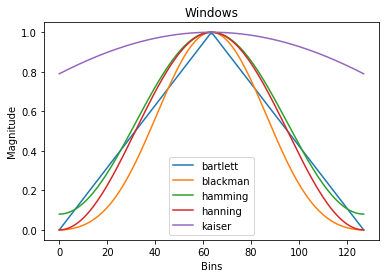

In [2]:
M = 128
plt.plot(np.bartlett(M))
plt.plot(np.blackman(M))
plt.plot(np.hamming(M))
plt.plot(np.hanning(M))
plt.plot(np.kaiser(M, beta=1))
plt.title("Windows")
plt.xlabel("Bins")
plt.ylabel("Magnitude")
plt.legend(["bartlett","blackman","hamming","hanning","kaiser"])

## Butterworth Filters
* Otra opción es aplicar filtros FIR más convencionales, en este caso de tipo butterworth.
* La funcion principal es spec_filters, la cual aplica un arreglo de filtros aleatorios sobre un batch de espectrogramas.
* La funcion butterworth_filters genera los filtros aleatorios.
* La funcion scale_filters convierte los filtros a escala Mel y adapta las amplitudes a decibeles.

In [16]:
def spec_filters(X_batch):
    batch_size, bin_size, frame_size, n_channels = np.shape(X_batch) 
    X_batch = np.reshape(X_batch,newshape=(batch_size,bin_size,frame_size))
    batch_filters = scale_filters(butterworth_filters(bin_size=bin_size,n_filters=batch_size),n_mels=bin_size)
    batch_matrices = [np.tile(batch_filter,(bin_size,1)).transpose() for batch_filter in batch_filters]
    filtered_batch = [x*np.flipud(matrix) for x,matrix in zip(X_batch,batch_matrices)]
    return np.reshape(filtered_batch,newshape=(batch_size, bin_size, frame_size,n_channels)) 

def butterworth_filters(bin_size,n_filters=1,wc_lims=[0.4,1],n_lims=[1,20]):
    w_norm = np.linspace(0,1,bin_size)
    butterworth_filters = []
    while n_filters>0:
        wc = np.random.uniform(*wc_lims)
        n  = np.random.randint(*n_lims)       
        butterworth_lpf = [1/np.sqrt(1+(w/wc)**(2*n)) for w in w_norm]
        butterworth_hpf = np.flip(butterworth_lpf)
        butterworth_bpf = butterworth_lpf * butterworth_hpf
        butterworth_filters.append(butterworth_bpf)
        n_filters-=1
    return butterworth_filters

def scale_filters(filter_arrays,n_mels,f_max=20000):
    mel_freqs = librosa.core.mel_frequencies(n_mels=n_mels, fmin=0.0, fmax=f_max, htk=False)
    mel_indeces = [int(np.floor(freq*n_mels/f_max)) for freq in mel_freqs]
    filtered_arrays = []
    for filter_array in filter_arrays:
        filtered_array = np.flip([filter_array[index] for index in mel_indeces]) # mel_scale
        filtered_array = scipy.signal.savgol_filter(filtered_array,window_length=9,polyorder=3) # smooth
        while np.any(filtered_array <=0): filtered_array += 0.01
        filtered_array = (20 * np.log10(filtered_array) + 80)/80 # convert to dB & normalize
        filtered_arrays.append(filtered_array)
    return filtered_arrays

* Los filtros BPF resultantes se obitenen al multiplicar un LPF butterworth con un HPF butterworth (LPF invertido en frecuencia).
* Los filtros son aleatorios porque se utiliza un generador de numeros aleatorios para configurar la frecuencia de corte y el orden del filtro. Debido a que es un BPF simetrico, la frecuencia de paso siempre estará centrada en la mitad de los componentes de frecuencia, que coincide con 600 Hz.
* Es importante adaptar las matrices de filtros a escala Mel y en decibeles para porder multiplicarse con los espectrogramas

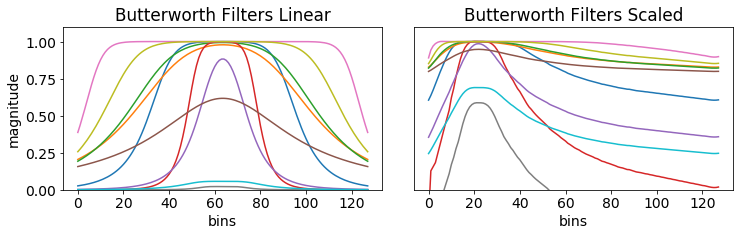

In [143]:
plt.figure(figsize=(12,3))
linear_filters=butterworth_filters(bin_size=128,n_filters=10,wc_lims=[0.4,1],n_lims=[1,20])
scaled_filters=scale_filters(filter_arrays=linear_filters,n_mels=128,f_max=20000)
plt.subplot(121)
for butter in linear_filters:
    plt.plot(butter) 
plt.ylim([0,1.1]) 
plt.title("Butterworth Filters Linear")
plt.xlabel("bins")
#plt.xlabel('Frequency [Hz]')
plt.ylabel("magnitude")
plt.subplot(122)
for butter in scaled_filters:
    plt.plot(butter) 
plt.ylim([0,1.1]) 
plt.yticks([])
plt.title("Butterworth Filters Scaled")
plt.xlabel("bins")
plt.subplots_adjust(wspace=0.1)
plt.savefig("Butterworth Bandpass Filters 2",dpi=300,bbox_inches='tight')

Como ejemplo, se aplica la funcion sobre un batch que contiene un espectrograma de estación de subte

In [21]:
path = "J:\\DataOffline\\Datasets\\SOUND_SCENES_MELSPECTROGRAM\\tut17_09_metro_station\\09_metro_station_hpf_200_6dB.wav_1.npy"
temp_spec = np.load(path)
temp_spec = (temp_spec + 80)/80
temp_spec = np.reshape(temp_spec,(128,128,1))
X_batch= [temp_spec]
batch_size, bin_size, frame_size, n_channels = np.shape(X_batch) 
X_batch = np.reshape(X_batch,newshape=(batch_size,bin_size,frame_size))
batch_filters = scale_filters(butterworth_filters(bin_size=bin_size,n_filters=batch_size),n_mels=bin_size)
batch_matrices = [np.tile(batch_filter,(bin_size,1)).transpose() for batch_filter in batch_filters]
filtered_batch = [x*np.flipud(matrix) for x,matrix in zip(X_batch,batch_matrices)]

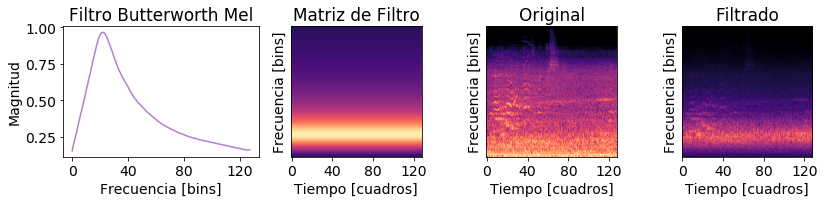

In [112]:
index=0
plt.figure(figsize=(14,2.4))
plt.tight_layout()
plt.subplot(141)
plt.subplots_adjust(wspace=0)
plt.xticks([0,40,80,120])
plt.title("Filtro Butterworth Mel")
plt.plot(batch_filters[index],color=[0.7,0.5,0.8])
plt.ylabel("Magnitud")
plt.xlabel("Frecuencia [bins]")
plt.subplot(142)
plt.xticks([0,40,80,120])
plt.subplots_adjust(wspace=0)
plt.yticks([])
plt.title("Matriz de Filtro")
plt.ylabel("Frecuencia [bins]")
plt.xlabel("Tiempo [cuadros]")
plt.imshow(np.flipud(batch_matrices[index]),vmin=0,vmax=1,cmap="magma")
plt.subplot(143)
plt.subplots_adjust(wspace=0)
plt.xticks([0,40,80,120])
plt.yticks([])
plt.ylabel("Frecuencia [bins]")
plt.xlabel("Tiempo [cuadros]")
plt.title("Original")
plt.imshow(temp_spec.reshape(128,128),vmin=0,vmax=1,cmap="magma")
plt.subplot(144)
plt.subplots_adjust(wspace=0)
plt.xticks([0,40,80,120])
plt.yticks([])
plt.ylabel("Frecuencia [bins]")
plt.xlabel("Tiempo [cuadros]")
plt.title("Filtrado")
plt.imshow(filtered_batch[index],vmin=0,vmax=1,cmap="magma")
#plt.colorbar()
plt.subplots_adjust(wspace=0)
plt.savefig("Butterworth Bandpass Example",dpi=300,bbox_inches='tight')

La relacion entre bins y frecuencias Mel está dada de la siguiente forma. 

In [21]:
import csv
mel_freqs = librosa.core.mel_frequencies(n_mels=128, fmin=0.0, fmax=20000, htk=False)
lin_freqs = librosa.core.fft_frequencies()
with open("mel_freqs.csv",'w') as csvfile:
    writer =  csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    for freq in list(mel_freqs):
        writer.writerow([freq])
        
for i,freq in enumerate(mel_freqs):
    print(i,"--->",round(freq,2))

0 ---> 0.0
1 ---> 30.75
2 ---> 61.49
3 ---> 92.24
4 ---> 122.99
5 ---> 153.74
6 ---> 184.48
7 ---> 215.23
8 ---> 245.98
9 ---> 276.72
10 ---> 307.47
11 ---> 338.22
12 ---> 368.96
13 ---> 399.71
14 ---> 430.46
15 ---> 461.21
16 ---> 491.95
17 ---> 522.7
18 ---> 553.45
19 ---> 584.19
20 ---> 614.94
21 ---> 645.69
22 ---> 676.44
23 ---> 707.18
24 ---> 737.93
25 ---> 768.68
26 ---> 799.42
27 ---> 830.17
28 ---> 860.92
29 ---> 891.66
30 ---> 922.41
31 ---> 953.16
32 ---> 983.91
33 ---> 1015.23
34 ---> 1047.93
35 ---> 1081.69
36 ---> 1116.54
37 ---> 1152.51
38 ---> 1189.65
39 ---> 1227.97
40 ---> 1267.53
41 ---> 1308.37
42 ---> 1350.52
43 ---> 1394.03
44 ---> 1438.94
45 ---> 1485.3
46 ---> 1533.15
47 ---> 1582.54
48 ---> 1633.53
49 ---> 1686.16
50 ---> 1740.48
51 ---> 1796.55
52 ---> 1854.43
53 ---> 1914.17
54 ---> 1975.84
55 ---> 2039.5
56 ---> 2105.2
57 ---> 2173.03
58 ---> 2243.03
59 ---> 2315.3
60 ---> 2389.89
61 ---> 2466.88
62 ---> 2546.36
63 ---> 2628.4
64 ---> 2713.07
65 ---> 2800.48